# Extract $\frac{1}{N_C}Tr(A_\perp^2)$ to compare with classical simulation

### Set up and configuration

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
N = 128 
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5


g = 2.0          		
mu = g2mu / g**2

ns = 50      

nevents = 1

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.pi_fields as pi

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Simulation

Define the simultion routine

In [3]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    nplus = maxt//DTS
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create objects to store the necessary fields
    # up = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    # Ay = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    Az = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create the object Glasma fields
    gf = pi.GlasmaFields(s)
    gf.init()
    
    # We simulate the event and store the fields when the spatial and temporal lattices match
    with tqdm(total=nplus) as pbar:    
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # Store the fields
            if t % DTS == 0:
                
                xplus = t//DTS
                
                gf.compute_fields(xplus, a/hbarc)
                
                # up[xplus] = gf.up.copy()
                # Ay[xplus] = gf.ay.copy()
                Az[xplus] = gf.az.copy()
                
                pbar.update(1) 
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    # We write the transformed fields in a dictionary
    # output["up"] = up
    # output["Ay"] = Ay
    output["Az"] = Az
    
    return output

Run the simulation

In [4]:
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    print('Event %i' % n)
    output = simulate()
    
    # up = output['up']
    # Ay = output['Ay']
    Az = output['Az']

    # # Go up one level from 'notebooks' to parent, then into 'simulations/tuomas_guess'
    # save_dir = os.path.join('..', 'simulations', 'tuomas_guess')
    # os.makedirs(save_dir, exist_ok=True)

    # np.save(os.path.join(save_dir, 'up_%i.npy' % n), up)
    # np.save(os.path.join(save_dir, 'Ay_%i.npy' % n), Ay)
    # np.save(os.path.join(save_dir, 'Az_%i.npy' % n), Az)
    

Event 0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


### Plot the results

In [5]:
A0 = Az[:, 0, :].reshape(maxt//DTS, 3, 3)

In [10]:
print(A0[2])

[[ 2.68155095e-02+4.22673767e-20j  1.51713953e-05+2.29980502e-02j
   3.67196293e-02-2.34289854e-02j]
 [ 1.51713953e-05-2.29980502e-02j  9.08684956e-03-3.38423115e-20j
  -4.97530318e-02+3.93997480e-02j]
 [ 3.67196293e-02+2.34289854e-02j -4.97530318e-02-3.93997480e-02j
  -3.59023591e-02-6.50336248e-20j]]


In [6]:
A2 = np.array([A0[xplus] @ A0[xplus] for xplus in range(nplus)])

In [7]:
A_av = [1/3 * np.trace(A0[xplus]) for xplus in range(nplus)]

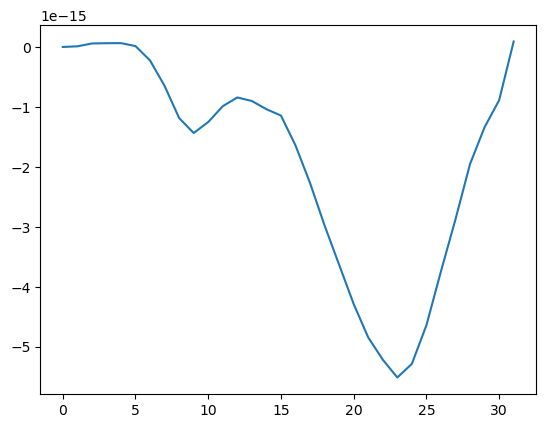

In [9]:
import matplotlib.pyplot as plt

plt.plot(A_av)